**Section 1: Import Libraries**

In [91]:
import requests   # This library helps us to fetch data from API
import pandas as pd   #For handling data & analysing data
import numpy as np  #For numerical operations
import matplotlib.pyplot as plt  #For data visualization
import seaborn as sns  #For data visualization
from sklearn.model_selection import train_test_split  #To splitting data into training & testing sets
from sklearn.preprocessing import LabelEncoder  #To convert categorical data into numerical values
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor  #Models for classification & Regression task
from sklearn.metrics import mean_squared_error  #To measure the accuracy of our predictions
from datetime import datetime, timedelta  #To handle data and time
import pytz


In [92]:
API_KEY = '4f11761b24243b03d59507095ac919f9'  #API key from openweathermap.org
BASE_URL = 'https://api.openweathermap.org/data/2.5/' #Base url for making API requests

**1. Fetch Current Weather Data**



In [105]:
def get_current_weather(city):
  url = f"{BASE_URL}weather?q={city}&appid={API_KEY}&units=metric"  #Contruct the API request URL
  response = requests.get(url) #send the get request to API
  data = response.json()
  return {
      'city': data['name'],
      'current_temp': round(data['main']['temp']),
      'feels_like': round(data['main']['feels_like']),
      'temp_min': round(data['main']['temp_min']),
      'temp_max' : round(data['main']['temp_max']),
      'humidity': round(data['main']['humidity']),
      'description': data['weather'][0]['description'],
      'country': data['sys']['country'],
      'wind_gust_dir': data['wind']['deg'],
      'pressure': data['main']['pressure'],
      'Wind_Gust_Speed': data['wind']['speed']
  }

**2. Read Historical Data**

In [94]:
def read_historical_data(filename):
  df = pd.read_csv(filename)
  df = df.dropna() #remove rows with missing values
  df = df.drop_duplicates()
  return df

**DATA VISUALIZATION**

**Histogram**

Columns: ['MinTemp', 'MaxTemp', 'WindGustDir', 'WindGustSpeed', 'Humidity', 'Pressure', 'Temp', 'RainTomorrow']


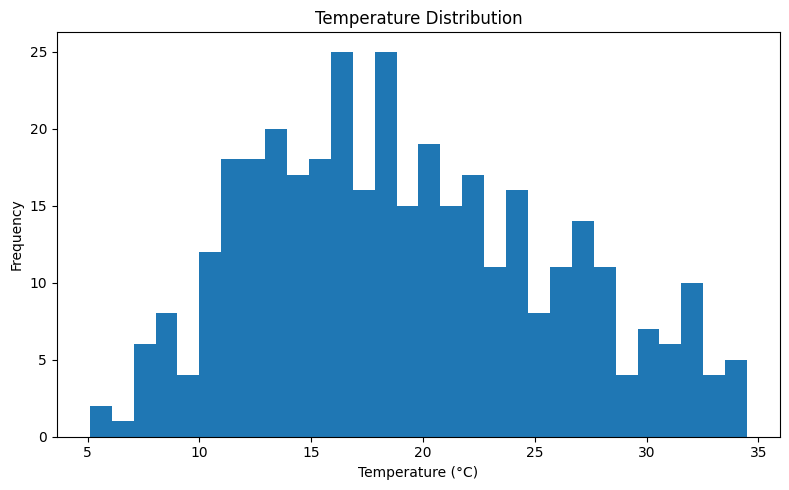

In [95]:
historical_data = read_historical_data('/content/weather.csv')

print("Columns:", historical_data.columns.tolist())

plt.figure(figsize=(8,5))
plt.hist(historical_data['Temp'], bins=30)
plt.title("Temperature Distribution")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

**Heatmap**

Columns: ['MinTemp', 'MaxTemp', 'WindGustDir', 'WindGustSpeed', 'Humidity', 'Pressure', 'Temp', 'RainTomorrow']


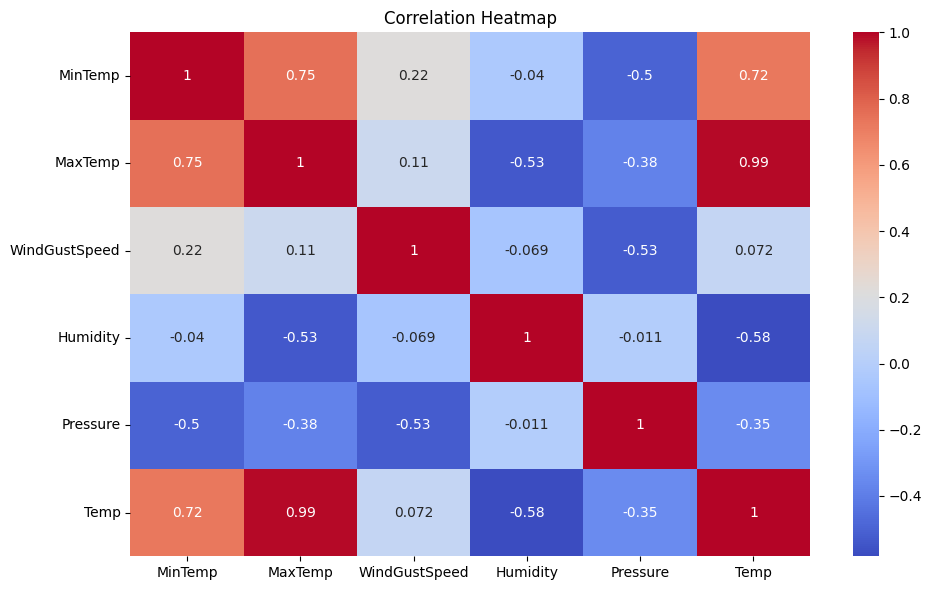

In [96]:
historical_data = read_historical_data('/content/weather.csv')

print("Columns:", historical_data.columns.tolist())

numeric_data = historical_data.select_dtypes(include=['int64','float64'])
plt.figure(figsize=(10,6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

Columns: ['MinTemp', 'MaxTemp', 'WindGustDir', 'WindGustSpeed', 'Humidity', 'Pressure', 'Temp', 'RainTomorrow']


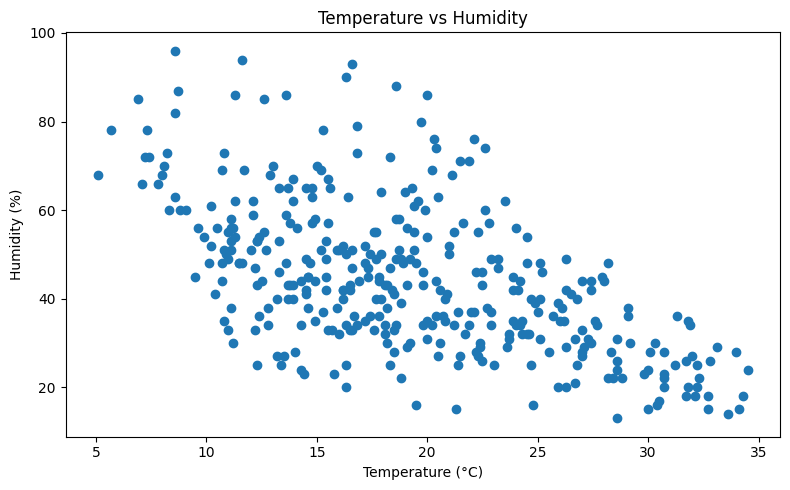

In [97]:
historical_data = read_historical_data('/content/weather.csv')

print("Columns:", historical_data.columns.tolist())

plt.figure(figsize=(8,5))
plt.scatter(historical_data['Temp'], historical_data['Humidity'])
plt.xlabel("Temperature (°C)")
plt.ylabel("Humidity (%)")
plt.title("Temperature vs Humidity")
plt.tight_layout()
plt.show()

**3. Prepare data for training**

In [98]:
def prepare_data(data):
  le = LabelEncoder() #Create a LabelEncoder instance
  data['WindGustDir'] = le.fit_transform(data['WindGustDir'])
  data['RainTomorrow'] = le.fit_transform(data['RainTomorrow'])

  #Define the feature variables and target variables
  X = data[['MinTemp', 'MaxTemp', 'WindGustDir', 'WindGustSpeed', 'Humidity', 'Pressure', 'Temp']]  #Feature variables
  y = data['RainTomorrow']  #Target variable

  return X, y, le  #return feature variable, target variable and the label encoder


**4. Train Rain Prediction Model**

In [99]:
def train_rain_model(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model = RandomForestClassifier(n_estimators=100, random_state=42) #100 decision trees aloted and same random state for each to give accurate results
  model.fit(X_train, y_train) #Train the model

  y_pred = model.predict(X_test) #To make predictions on test set

  print("Mean Squared Error for Rain Model")

  print(mean_squared_error(y_test, y_pred))

  return model

**5. Prepare Regression Data**

In [101]:
def prepare_regression_data(data, feature): # X is for feature values & y is for target values.
  X, y = [], [] #Initialize list for feature and target values

  for i in range(len(data) - 1):
    X.append(data[feature].iloc[i])

    y.append(data[feature].iloc[i+1])

  X = np.array(X).reshape(-1, 1)
  y = np.array(y)
  return X, y

**Train Regression Model**

In [102]:
def train_regression_model(X, y):
  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(X, y)
  return model

**Predict Future**

In [103]:
def predict_future(model, current_value):
  predictions = [current_value]

  for i in range(5):
    next_value = model.predict(np.array([[predictions[-1]]]))

    predictions.append(next_value[0])

  return predictions[1:]

**Weather Analysis Function**

In [104]:
def weather_view():
  city = input("Enter the city name: ")
  current_weather = get_current_weather(city)

  #load historical data
  historical_data = read_historical_data('/content/weather.csv')

  #prepare & train the rain prediction model
  X, y, le = prepare_data(historical_data)

  rain_model = train_rain_model(X, y)

  #Map wind direction to compass points
  wind_deg = current_weather['wind_gust_dir'] % 360
  compass_points = [
      ("N", 0, 11.25), ("NNE", 11.25, 33.75), ("NE", 33.75, 56.25),
      ("ENE", 56.25, 78.75), ("E", 78.75, 101.25), ("ESE", 101.25, 123.75),
      ("SE", 123.75, 146.25), ("SSE", 146.25, 168.75), ("S", 168.75, 191.25),
      ("SSW", 191.25, 213.75), ("SW", 213.75, 236.25), ("WSW", 236.25, 258.75),
      ("W", 258.75, 281.25), ("WNW", 281.25, 303.75), ("NW", 303.75, 326.25),
      ("NNW", 326.25, 348.75)
  ]
  compass_direction = next(point for point, start, end in compass_points if start <= wind_deg < end)

  compass_direction_encoded = le.transform([compass_direction])[0] if compass_direction in le.classes_ else -1

  current_data = {
      'MinTemp': current_weather['temp_min'],
      'MaxTemp': current_weather['temp_max'],
      'WindGustDir': compass_direction_encoded,
      'WindGustSpeed': current_weather['Wind_Gust_Speed'],
      'Humidity': current_weather['humidity'],
      'Pressure': current_weather['pressure'],
      'Temp': current_weather['current_temp'],
  }

  current_df = pd.DataFrame([current_data])


  #Rain prediction

  rain_prediction = rain_model.predict(current_df)[0]


  #Prepare regression model for temperature and humidiy

  X_temp, y_temp = prepare_regression_data(historical_data, 'Temp')
  X_hum, y_hum = prepare_regression_data(historical_data, 'Humidity')

  temp_model = train_regression_model(X_temp, y_temp)
  hum_model = train_regression_model(X_hum, y_hum)


  #Predict future temperature & humidity
  future_temp = predict_future(temp_model, current_weather['temp_min'])
  future_humidity = predict_future(temp_model, current_weather['humidity'])



  #Prepare time for future predictions

  timezone = pytz.timezone('Asia/Kolkata')
  now = datetime.now(timezone)
  next_hour = now + timedelta(hours=1)
  next_hour = next_hour.replace(minute=0, second=0, microsecond=0)

  future_times = [(next_hour + timedelta(hours=i)).strftime("%H:00") for i in range(5)]

  #Display results

  print(f"City: {city}, {current_weather['country']}")
  print(f"Current Temperature: {current_weather['current_temp']}")
  print(f"Feels Like: {current_weather['feels_like']}")
  print(f"Minimum Temperature: {current_weather['temp_min']}°C")
  print(f"Maximum Temperature: {current_weather['temp_max']}°C")
  print(f"Humidity: {current_weather['humidity']}%")
  print(f"Weather Prediction: {current_weather['description']}")
  print(f"Rain Prediction: {'Yes' if rain_prediction else "No"}")

  print("\nFuture Temperature Predictions:")
  for time, temp in zip(future_times, future_temp):
    print(f"{time}: {round(temp, 1)}°C")


  print("\nFuture Humidity Predictions:")
  for time, humidity in zip(future_times, future_humidity):
    print(f"{time}: {round(humidity, 1)}%")

weather_view()

Enter the city name: chennai
Mean Squared Error for Rain Model
0.1506849315068493
City: chennai, IN
Current Temperature: 28
Feels Like: 32
Minimum Temperature: 27°C
Maximum Temperature: 29°C
Humidity: 80%
Weather Prediction: mist
Rain Prediction: Yes

Future Temperature Predictions:
16:00: 28.1°C
17:00: 25.1°C
18:00: 20.1°C
19:00: 16.6°C
20:00: 14.4°C

Future Humidity Predictions:
16:00: 33.1%
17:00: 25.1%
18:00: 20.1%
19:00: 16.6%
20:00: 14.4%
